In [1]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

In [3]:
# GPU환경으로 돌릴 수 있는 경우 cuda로, 아닐경우 cpu로 시작 => GPU환경이 좋아서 검사하는거라고함
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# cuda일 경우(=GPU환경이란 소리) 더 좋은 환경이기 떄문에 사이즈를 512로, 아니면 작은 128로
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)),  # 불러올 이미지 사이즈를 위의 imsize로 수정
    transforms.ToTensor()])     # 수정한 아이를 torch tensor로 변형

In [4]:
def image_loader(image_name):
    image = Image.open(image_name).convert('RGB')
    # 네트워크 사용하려면 fake batch를 통해 차원을 맞춰줍니다
    image = loader(image)
    image = image.unsqueeze(0)
    return image.to(device, torch.float)


# style_img = image_loader("./data/images/neural-style/crying.jpg")
# content_img = image_loader("./data/images/neural-style/me.jpg")

style_img = image_loader("./data/images/neural-style/crying.jpg")
content_img = image_loader("./data/images/neural-style/me.jpg")

print(style_img.size())
print(content_img.size())

torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])


In [5]:
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

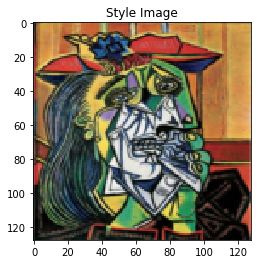

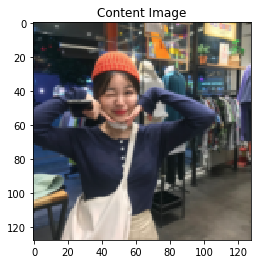

In [6]:
# 사본을 PIL형식으로 변환 후, plt.imshow()를 통해 이미지를 올바르게 가져왔는지 확인
unloader = transforms.ToPILImage()  #PIL이미지로 변경

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # 이미지를 복제하여 원본 손상 방지
    image = image.squeeze(0)      # 아까 생성했던 fake batch 삭제
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # linux환경에서는 pause하지 않으면 그림이 갱신되지 않는다고 함
                      # Mac은 하든 안하든 노상관


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [7]:
#content loss는 개별layer를 위한 content거리의 weighted 버전이라고 합니다. 음? 어렵네

#이 함수는 input X에 대한 layer L의 feature map을 취하고
#X와 content C 사이의 weighted 거리를 반환 (W*D)

#계산된 loss는 nn.Module의 매개변수로 저장
class ContentLoss(nn.Module):

    def __init__(self, target, ):
        super(ContentLoss, self).__init__()
        
        # dynamic하게 gradient를 계산하기 위해 detach 함
        # => 변수가 아닌 명시된 값 (target은 고정값이라는 소리일까?)
        # 이유 : 전달할때 오류생긴다고 함 자세한건 모르겠음
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
#모델 import
cnn = models.vgg19(pretrained=True).features.to(device).eval()


cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)


# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [10]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_2']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        print(model)
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        elif isinstance(layer, nn.Linear):
            name = 'fc_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

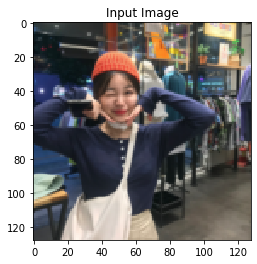

In [11]:
######################################################################
# Next, we select the input image. You can use a copy of the content image
# or white noise.
# 

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [12]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=350,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
                                                                     normalization_mean, normalization_std, style_img,
                                                                     content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/Users/yungoing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/Users/yungoing/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Sequential(
  (0): Normalization()
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_2): ContentLoss()
  (style_loss_2): StyleLoss()
)
Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_2): ContentLoss()
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
)
Sequential(
  (0): Normaliz

run [50]:
Style Loss : 220.930984 Content Loss: 4.892358

run [100]:
Style Loss : 87.588837 Content Loss: 6.122909

run [150]:
Style Loss : 52.077198 Content Loss: 6.872955

run [200]:
Style Loss : 36.792358 Content Loss: 7.374886

run [250]:
Style Loss : 29.206985 Content Loss: 7.690969

run [300]:
Style Loss : 24.283865 Content Loss: 7.946815

run [350]:
Style Loss : 21.225744 Content Loss: 8.116813



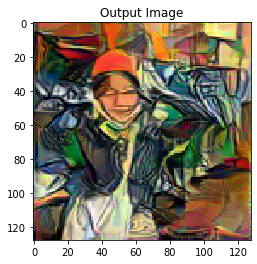

In [13]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [16]:
from torchvision.utils import save_image

img = output[0]
save_image(img, './data/images/output/test.jpg')